# Scrapbook

Imports

In [43]:
import os
import shutil
import pickle
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage import io
import cv2

Constants

In [44]:
RAW_DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw')
DATA_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_info.csv')

PROCESSED_DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 
                                   'processed', 'data_to_tf_data.npy')
PROCESSED_LABELS_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 
                                     'processed', 'labels_to_tf_data.npy')


Loading in the data

In [45]:
painting_data = pd.read_csv(DATA_CSV_PATH)

Rewriting stuff into functions

In [46]:
# images_array = []
# labels_array = []

# for style in new_styles:
#     concatenate_images = painting_data[painting_data['style'] == style].head(1100)['filename'].values
#     concatenate_labels = painting_data[painting_data['style'] == style].head(1100)['style'].values
#     images_array = np.append(images_array, concatenate_images)
#     labels_array = np.append(labels_array, concatenate_labels)    

new_styles_array = ['Impressionism', 'Realism', 'Romanticism', 'Expressionism',
                    'Art Nouveau (Modern)', 'Baroque', 'Surrealism', 'Symbolism',
                    'Cubism', 'Ukiyo-e']

In [47]:
#we'll take an array with styles and get two arrays, 
#one with image name (its number) and the corresponding style

def get_names_and_styles(styles):
    images_array = []
    labels_array = []

    for style in styles:
        concatenate_images = painting_data[painting_data['style'] == style].head(2)['filename'].values
        concatenate_labels = painting_data[painting_data['style'] == style].head(2)['style'].values
        images_array = np.append(images_array, concatenate_images)
        labels_array = np.append(labels_array, concatenate_labels) 
    
    return images_array, labels_array    

In [48]:
images_array, labels_array = get_names_and_styles(new_styles_array)

In [57]:
images_array[:2], labels_array.shape

(array(['95360.jpg', '49757.jpg'], dtype=object), (20,))

Realism


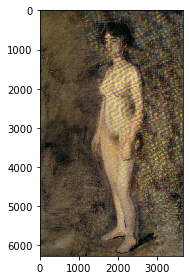

In [50]:
sample_image_path = os.path.join(RAW_DATA_PATH, images_array[3])
io.imshow(sample_image_path)

print(labels_array[3])

In [42]:
# for image, label in zip(images_array, labels_array):
#     current_file = os.path.join(RAW_DATA_PATH, image)
    
#     new_file_path = str(os.path.join(os.path.dirname(RAW_DATA_PATH), 
#                                      'interim', f'{index}_{label}.jpg')).split(os.path.sep)[-1].split('_')[1].upper().replace('.JPG', '')
#     label_check = label.upper()
#     print(current_file, new_file_path)    

In [62]:
def prepare_img_data(array_of_imgs, array_of_labels, img_width=200, img_height=200):
    X = []
    y = []
    
    for image, label in zip(images_array, labels_array):
        current_file = os.path.join(RAW_DATA_PATH, image)
        
        try:
            X.append(np.array(cv2.resize((cv2.imread(current_file, cv2.IMREAD_GRAYSCALE)), 
                                         (img_width, img_height))))
            y.append(label.upper())
        except Exception as e:
            print(f"Corrupted image: {image}, skipping the image")
            print(e)
    
    return X, y

In [63]:
data, labels = prepare_img_data(images_array, labels_array)

E:\Projekty\Github-repositories\painting-style-classification\data\raw\95360.jpg
IMPRESSIONISM
E:\Projekty\Github-repositories\painting-style-classification\data\raw\49757.jpg
IMPRESSIONISM
E:\Projekty\Github-repositories\painting-style-classification\data\raw\28908.jpg
REALISM
E:\Projekty\Github-repositories\painting-style-classification\data\raw\633.jpg
REALISM
E:\Projekty\Github-repositories\painting-style-classification\data\raw\99442.jpg
ROMANTICISM
E:\Projekty\Github-repositories\painting-style-classification\data\raw\7486.jpg
ROMANTICISM
E:\Projekty\Github-repositories\painting-style-classification\data\raw\31234.jpg
EXPRESSIONISM
E:\Projekty\Github-repositories\painting-style-classification\data\raw\65341.jpg
EXPRESSIONISM
E:\Projekty\Github-repositories\painting-style-classification\data\raw\41541.jpg
ART NOUVEAU (MODERN)
E:\Projekty\Github-repositories\painting-style-classification\data\raw\71560.jpg
ART NOUVEAU (MODERN)
E:\Projekty\Github-repositories\painting-style-classifi

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# def prepare_img_data(path_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
#     X = []
#     y = []
#     for value in path_list:
#         try:
#             X.append(np.array(cv2.resize((cv2.imread(value, cv2.IMREAD_GRAYSCALE)), 
#                                          (img_width, img_height))))
#             y.append(str.split(value, os.path.sep)[-1]
#                      .split('_')[1]
#                      .upper()
#                      .replace('.JPG', ''))
#         except Exception as e:
#             print(f"Corrupted image: {value}, skipping the image")
#     return X, y

In [ ]:
# data, labels = prepare_img_data(img_path_list)

In [66]:
len(data), len(labels)

(20, 20)

In [68]:
# np.save(PROCESSED_DATA_PATH, data)
# np.save(PROCESSED_LABELS_PATH, labels)

X = np.load(PROCESSED_DATA_PATH)
y = np.load(PROCESSED_LABELS_PATH)

In [69]:
unique, count = np.unique(y, return_counts=True)
occurences = dict(zip(unique, count))
print(f"The number of occurences of each class in the dataset = \n{occurences}")

The number of occurences of each class in the dataset = 
{'ART NOUVEAU (MODERN)': 2, 'BAROQUE': 2, 'CUBISM': 2, 'EXPRESSIONISM': 2, 'IMPRESSIONISM': 2, 'REALISM': 2, 'ROMANTICISM': 2, 'SURREALISM': 2, 'SYMBOLISM': 2, 'UKIYO-E': 2}


In [70]:
def shuffle_data(image_data, label_data, random_seed):
    return np.random.RandomState(random_seed).permutation(image_data), np.random.RandomState(random_seed).permutation(label_data)

def display_rand_imgs(image_data, label_data, random_seed):
    images, labels = shuffle_data(image_data, label_data, random_seed)
    
    fig, axes = plt.subplots(3, 3, figsize = (15,15))
    plt.suptitle("Random images and their labels", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(0, len(label_data))
            image = images[index]
            label = labels[index]
            axis.imshow(image, cmap='Greys')
            axis.set_title(f"Class: {label}")
            axis.set_axis_off()

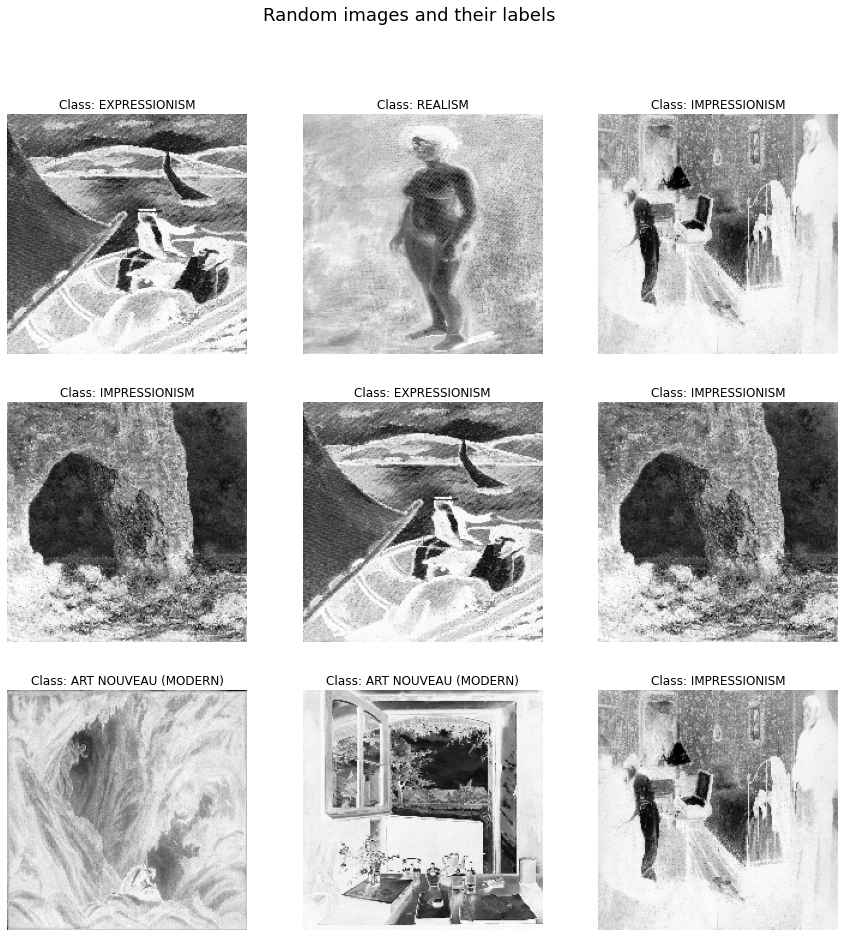

In [71]:
display_rand_imgs(X, y, 7)